In [192]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

import datetime
from time import gmtime, strftime, time

from nd_legacy import *

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
from bot_slacker import send_slack_message, send_slack_picture
send_slack_message("test (startup)")

### Load data

In [195]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

In [196]:
chan_names = ecog_matfile['chan_names']

In [197]:
chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

In [198]:
chan_names

[u'P3_1_d',
 u'P3_2_d',
 u'F3_1_d',
 u'F3_2_d',
 u'C3_1_d',
 u'C3_2_d',
 u'C3_3_d',
 u'C3_4_d',
 u'T5_1_d',
 u'T5_2_d',
 u'T5_3_d',
 u'T5_4_d']

In [199]:
raw_data.shape

(12, 136001)

In [200]:
mv_acc.shape


(1, 136001)

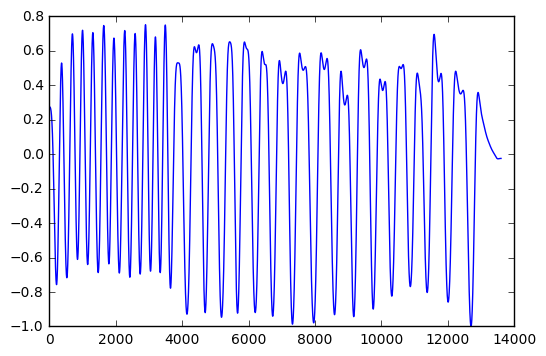

In [201]:
plt.plot(mv_acc[0,::10])

In [202]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#mmsc = MinMaxScaler(feature_range=(0, 1))                            
#raw_data = mmsc.fit_transform(raw_data.T).T
#mv_acc = mmsc.fit_transform(mv_acc.T).T
#raw_acc = mmsc.fit_transform(raw_acc.T).T

In [203]:
len_raw_data = raw_data.shape[1]

In [204]:
raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):]

#mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
#mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
#mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

mv_acc_train = raw_acc[:,0:(len_raw_data//2)]
mv_acc_val = raw_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = raw_acc[:,(2*len_raw_data//3):]

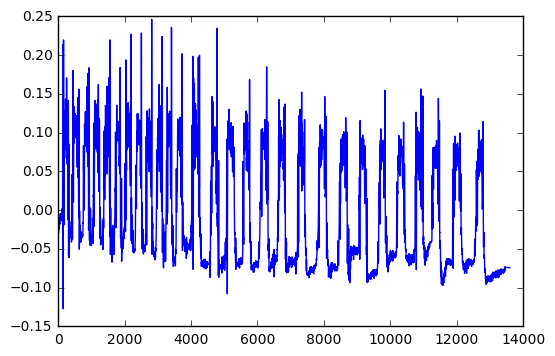

In [205]:
raw_acc = ecog_matfile['raw_acc']
plt.plot(raw_acc[0,::10])

In [206]:
sampling_rate = 2000

In [207]:
0.5*2000

1000.0

In [208]:
raw_acc.shape

(1, 136001)

In [209]:
raw_acc_f = butter_bandpass_filter(raw_acc, 0.1, 1, sampling_rate, order=3, how_to_filt = 'separately')
raw_acc_f.shape

(1, 136001)

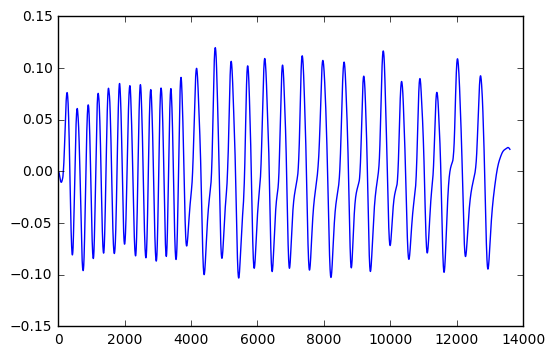

In [210]:
plt.plot(raw_acc_f[0,::10])

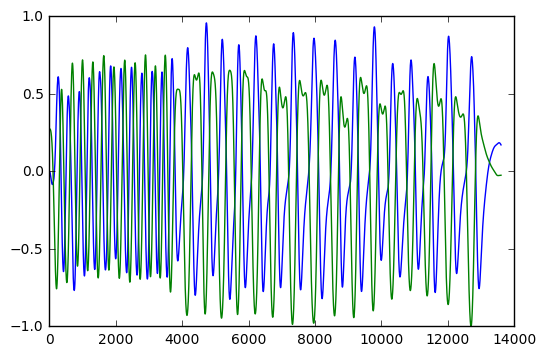

In [211]:
plt.plot(8*raw_acc_f[0,::10],'b',mv_acc[0,::10],'g')

In [212]:
raw_acc = raw_acc_f

In [213]:
#mv_acc_train = raw_acc[:,0:(len_raw_data//2)]
#mv_acc_val = raw_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
#mv_acc_test = raw_acc[:,(2*len_raw_data//3):]

In [214]:
print(raw_data_train.shape)
print(raw_data_val.shape)
print(raw_data_test.shape)
print(mv_acc_train.shape)
print(mv_acc_val.shape)
print(mv_acc_test.shape)

(4, 68000)
(4, 22667)
(4, 45334)
(1, 68000)
(1, 22667)
(1, 45334)


In [215]:
mv_acc[0,::10].shape

(13601,)

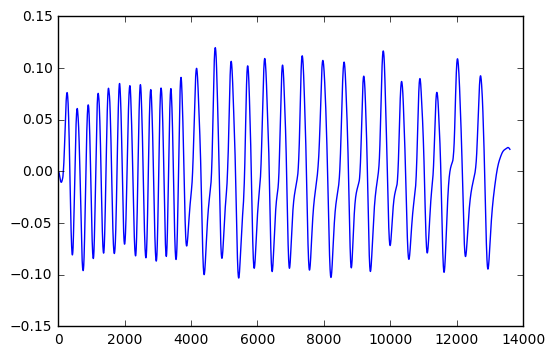

In [216]:
plt.plot(raw_acc[0,::10])

### Functions for data generation (to fit with fit_generator)

In [217]:
def generate_slice(slice_len, pos=2, val=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    else:
        X = raw_data_train
        y = mv_acc_train
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_mid = slice_start + slice_len//2
        slice_x = X[:,slice_start:slice_end].T
        
        if pos==0:
            slice_y = y[0,slice_start]
        elif pos==1:
            slice_y = y[0,slice_mid]
        else:            
            slice_y = y[0,slice_end]

        return slice_x, slice_y

In [182]:
def data_generator(batch_size, slice_len, pos=2, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, pos, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

### Training neural network

In [183]:
from keras.layers import Conv1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

#### Params

In [184]:
slice_len = 500

nb_filters = 10
kernel_size = 3

conv1d_act = "relu"

dense1_n = 100
dense1_act = "relu"

dense2_n = 100
dense2_act = "relu"

do = 0

path_to_save_model = 'testmodel2'

#### Architecture

In [185]:
input_seq = Input(shape=(slice_len, 4))
convolved = Conv1D(nb_filters, kernel_size, padding="same", activation=conv1d_act)(input_seq)
pooled = MaxPooling1D()(convolved)
flat = Flatten()(pooled)
dense1 = Dense(dense1_n, activation=dense1_act)(flat)
dense1do = Dropout(do)(dense1)
dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)

out = Dense(1, activation='linear')(dense2do)

model = Model(input=input_seq, output=out)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

model.summary()

#nb_epoch = 100000


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 500, 4)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 500, 10)           130       
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 250, 10)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2500)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               250100    
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               10100     
__________

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


#### Early stopping

In [29]:
samples_per_epoch = 1000
nb_val_samples = 500
nb_epoch = 200
patience = 10

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

#### Fit

In [30]:
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=32), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=32, val=True))

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1000, 200, callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., validation_steps=500)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/200
1000/1000 [==============================] - 14s - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.0866 - val_mean_squared_error: 0.0866
Epoch 2/200
  21/1000 [..............................] - ETA: 54s - loss: 0.0632 - mean_squared_error: 0.0632

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.990704). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.495851). Check your callbacks.
  % delta_t_median)


 825/1000 [=======================>......] - ETA: 1s - loss: 0.0595 - mean_squared_error: 0.0595

KeyboardInterrupt: 

['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss']


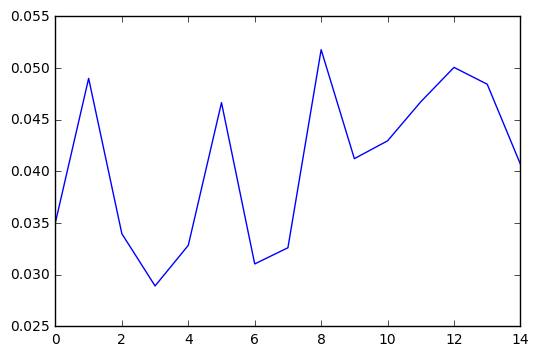

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_loss'])


### Testing

In [287]:
model = load_model('testmodel2')

In [290]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

In [291]:
k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

In [ ]:
tys_pred = model.predict(txs_0)

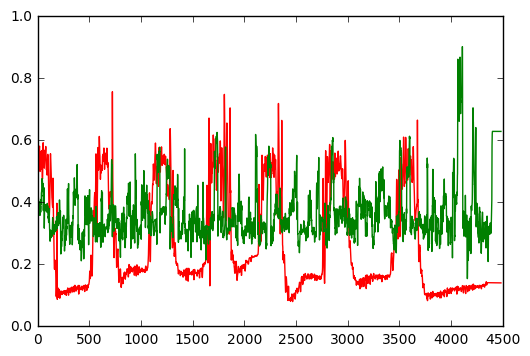

In [297]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()

# Cycle to iterate over parameter values

#### Prepare the network

In [218]:
from keras.layers import Conv1D, Dense, maximum, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

In [219]:
slice_len = 2000

nb_filters = 10
kernel_size = 3

conv1d_act = "relu"

dense1_n = 500
dense1_act = "relu"

dense2_n = 200
dense2_act = "relu"

samples_per_epoch = 1000
nb_val_samples = 500

nb_epoch = 100
patience = 10

batch_size = 32

#### Prepare testing data

In [220]:
pos = 2

In [221]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

# Prototype

In [222]:
input_seq = Input(shape=(slice_len, 4))

inputbn = BatchNormalization(axis = 1)(input_seq)

convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu')(inputbn)
convolvedbn = BatchNormalization()(convolved)
#convolvedbn = Dropout(0.1)(convolvedbn)
pooled = MaxPooling1D(pool_size=4)(convolvedbn)

convolved2 = Conv1D(nb_filters*4, kernel_size, padding="same", activation='relu')(pooled)
convolved2bn = BatchNormalization()(convolved2)
#convolved2bn = Dropout(0.2)(convolved2bn)
pooled2 = MaxPooling1D(pool_size=4)(convolved2bn)

convolved3 = Conv1D(nb_filters*16, kernel_size, padding="same", activation='relu')(pooled2)
convolved3bn = BatchNormalization()(convolved3)
#convolved3bn = Dropout(0.3)(convolved3bn)
pooled3 = MaxPooling1D(pool_size=4)(convolved3bn)

convolved4 = Conv1D(nb_filters*64, kernel_size, padding="same", activation='relu')(pooled3)
convolved4bn = BatchNormalization()(convolved4)
#convolved4bn = Dropout(0.4)(convolved4bn)
pooled4 = MaxPooling1D(pool_size=4)(convolved4bn)

#pooled4 = GlobalMaxPooling1D()(convolved4bn)

flat = Flatten()(pooled4)
#dense1 = Dense(dense1_n, activation='relu')(flat)
dense1 = maximum([Dense(dense1_n, activation='relu')(flat) for _ in range(2)])
dense1 = BatchNormalization()(dense1)
dense1do = Dropout(0)(dense1)
#dense2 = Dense(dense2_n, activation='relu')(dense1do)
#dense2 = BatchNormalization()(dense2)
#dense2do = Dropout(do)(dense2)

#ref: max_out = maximum([Dense(neurons, **dense_args)(input_layer) for _ in range(n_pieces)])
#out = maximum([Dense(1, activation='linear')(dense1do) for _ in range(2)])

out = Dense(1, activation='linear')(dense1do) 
model = Model(inputs=input_seq, outputs=out)
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 2000, 4)       0                                            
____________________________________________________________________________________________________
batch_normalization_85 (BatchNor (None, 2000, 4)       8000        input_16[0][0]                   
____________________________________________________________________________________________________
conv1d_58 (Conv1D)               (None, 2000, 10)      130         batch_normalization_85[0][0]     
____________________________________________________________________________________________________
batch_normalization_86 (BatchNor (None, 2000, 10)      40          conv1d_58[0][0]                  
___________________________________________________________________________________________

Epoch 1/100
1000/1000 [==============================] - 39s - loss: 0.1344 - mean_squared_error: 0.1344 - val_loss: 0.3370 - val_mean_squared_error: 0.3370
Epoch 2/100
1000/1000 [==============================] - 32s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 3/100
1000/1000 [==============================] - 32s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.1261 - val_mean_squared_error: 0.1261
Epoch 4/100
1000/1000 [==============================] - 32s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/100
1000/1000 [==============================] - 32s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0608 - val_mean_squared_error: 0.0608
Epoch 6/100
1000/1000 [==============================] - 32s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 7/100
1000/1000 [==============================] - 3

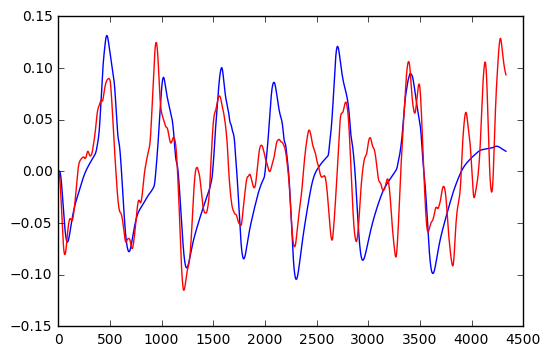

In [191]:
path_to_save_model_par = 'saved_model_do01'
figure_name = path_to_save_model_par+'_fig_0_'

# early stopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=1,
                           save_best_only=True, mode='auto', period=1)

# fit model
history = model.fit_generator(data_generator(slice_len=slice_len, pos=pos, batch_size=batch_size), 
                samples_per_epoch, 
                nb_epoch, 
                callbacks=[earlyStopping, checkpointer], 
                verbose=1, 
                validation_steps=nb_val_samples, 
                validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos, val=True))

# plot progress
plt.clf()
plt.plot(history.history['val_loss'])
plt.savefig(figure_name+'prog')

# test the best model

model = load_model(path_to_save_model_par)

tys_pred = model.predict(txs_0)

sampling_rate = 2000
tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

#tys_0_f = tys_0
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_0_f,'b')
plt.savefig(figure_name+'true')

plt.clf()
plt.plot(tys_pred,'g')
plt.plot(tys_pred_f,'b')
plt.savefig(figure_name+'pred')

plt.clf()
plt.plot(tys_0_f,'b')
plt.plot(tys_pred_f,'r')
plt.savefig(figure_name+'comp')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]

cor_sm_pred_only = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])
cor_sm_pred_only = cor_sm_pred_only[0,1]

cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth)+"\nCorrelation (only pred smoothed) = "+str(cor_sm_pred_only))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'comp'+'.png')

send_slack_message("true:")
send_slack_picture(figure_name+'true'+'.png')

send_slack_message("pred:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')


In [160]:
model = load_model(path_to_save_model_par)

history2 = model.fit_generator(data_generator(slice_len=slice_len, pos=pos, batch_size=batch_size), 
                samples_per_epoch, 
                nb_epoch, 
                callbacks=[earlyStopping, checkpointer], 
                verbose=1, 
                validation_steps=nb_val_samples, 
                validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos, val=True))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/home/ubuntu/anaconda2/lib/python2.7/encodings/utf_8.py", line 15, in decode
    def decode(input, errors='strict'):
KeyboardInterrupt


IndexError: string index out of range

In [223]:
np.arange(0,0.7,0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6])

In [ ]:
for do in np.arange(0,0.7,0.1):
    
    input_seq = Input(shape=(slice_len, 4))

    inputbn = BatchNormalization(axis = 1)(input_seq)

    convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu')(inputbn)
    convolvedbn = BatchNormalization()(convolved)
    #convolvedbn = Dropout(0.1)(convolvedbn)
    pooled = MaxPooling1D(pool_size=4)(convolvedbn)

    convolved2 = Conv1D(nb_filters*4, kernel_size, padding="same", activation='relu')(pooled)
    convolved2bn = BatchNormalization()(convolved2)
    #convolved2bn = Dropout(0.2)(convolved2bn)
    pooled2 = MaxPooling1D(pool_size=4)(convolved2bn)

    convolved3 = Conv1D(nb_filters*16, kernel_size, padding="same", activation='relu')(pooled2)
    convolved3bn = BatchNormalization()(convolved3)
    #convolved3bn = Dropout(0.3)(convolved3bn)
    pooled3 = MaxPooling1D(pool_size=4)(convolved3bn)

    convolved4 = Conv1D(nb_filters*64, kernel_size, padding="same", activation='relu')(pooled3)
    convolved4bn = BatchNormalization()(convolved4)
    #convolved4bn = Dropout(0.4)(convolved4bn)
    pooled4 = MaxPooling1D(pool_size=4)(convolved4bn)

    #pooled4 = GlobalMaxPooling1D()(convolved4bn)

    flat = Flatten()(pooled4)
    #dense1 = Dense(dense1_n, activation='relu')(flat)
    dense1 = maximum([Dense(dense1_n, activation='relu')(flat) for _ in range(2)])
    dense1 = BatchNormalization()(dense1)
    dense1do = Dropout(do)(dense1)
    #dense2 = Dense(dense2_n, activation='relu')(dense1do)
    #dense2 = BatchNormalization()(dense2)
    #dense2do = Dropout(do)(dense2)

    #ref: max_out = maximum([Dense(neurons, **dense_args)(input_layer) for _ in range(n_pieces)])
    #out = maximum([Dense(1, activation='linear')(dense1do) for _ in range(2)])

    out = Dense(1, activation='linear')(dense1do) 
    model = Model(inputs=input_seq, outputs=out)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])

    model.summary()


    path_to_save_model_par = 'saved_model'
    figure_name = 'fig_0_'

    # early stopping
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

    # fit model
    history = model.fit_generator(data_generator(slice_len=slice_len, pos=pos, batch_size=batch_size), 
                    samples_per_epoch, 
                    nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], 
                    verbose=1, 
                    validation_steps=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, pos=pos, val=True))

    # plot progress
    plt.clf()
    plt.plot(history.history['val_loss'])
    plt.savefig(figure_name+'prog')

    # test the best model

    model = load_model(path_to_save_model_par)

    tys_pred = model.predict(txs_0)

    sampling_rate = 2000
    tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

    #tys_0_f = tys_0
    tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

    plt.clf()
    plt.plot(tys_0,'g')
    plt.plot(tys_0_f,'b')
    plt.savefig(figure_name+'true')

    plt.clf()
    plt.plot(tys_pred,'g')
    plt.plot(tys_pred_f,'b')
    plt.savefig(figure_name+'pred')

    plt.clf()
    plt.plot(tys_0_f,'b')
    plt.plot(tys_pred_f,'r')
    plt.savefig(figure_name+'comp')

    cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
    cor = cor[0,1]

    cor_sm_pred_only = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])
    cor_sm_pred_only = cor_sm_pred_only[0,1]

    cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
    cor_smooth = cor_smooth[0,1]

    send_slack_message("dropout: "+ str(do))

    send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth)+"\nCorrelation (only pred smoothed) = "+str(cor_sm_pred_only))

    send_slack_message("Prediction:")
    send_slack_picture(figure_name+'comp'+'.png')

    send_slack_message("true:")
    send_slack_picture(figure_name+'true'+'.png')

    send_slack_message("pred:")
    send_slack_picture(figure_name+'pred'+'.png')

    send_slack_message("Training history:")
    send_slack_picture(figure_name+'prog'+'.png')




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 2000, 4)       0                                            
____________________________________________________________________________________________________
batch_normalization_91 (BatchNor (None, 2000, 4)       8000        input_17[0][0]                   
____________________________________________________________________________________________________
conv1d_62 (Conv1D)               (None, 2000, 10)      130         batch_normalization_91[0][0]     
____________________________________________________________________________________________________
batch_normalization_92 (BatchNor (None, 2000, 10)      40          conv1d_62[0][0]                  
___________________________________________________________________________________________

In [167]:

send_slack_message("dropout: "+ str(do))

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth)+"\nCorrelation (only pred smoothed) = "+str(cor_sm_pred_only))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'comp'+'.png')

send_slack_message("true:")
send_slack_picture(figure_name+'true'+'.png')

send_slack_message("pred:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')

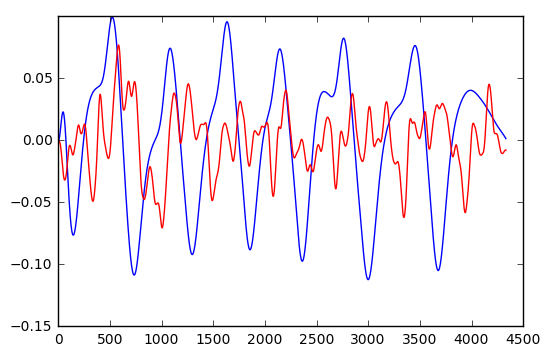

In [145]:
tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

#tys_0_f = tys_0
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_0_f,'b')
plt.savefig(figure_name+'true')

plt.clf()
plt.plot(tys_pred,'g')
plt.plot(tys_pred_f,'b')
plt.savefig(figure_name+'pred')

plt.clf()
plt.plot(tys_0_f,'b')
plt.plot(tys_pred_f,'r')
plt.savefig(figure_name+'comp')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]

cor_sm_pred_only = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])

cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth)+"\nCorrelation (only pred smoothed) = "+str(cor_sm_pred_only))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'comp'+'.png')

send_slack_message("true:")
send_slack_picture(figure_name+'true'+'.png')

send_slack_message("pred:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')

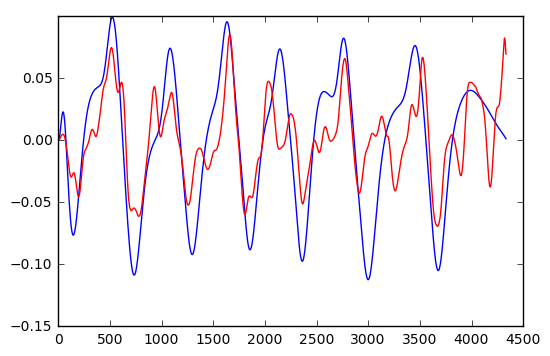

In [151]:
plt.clf()
plt.plot(tys_0_f,'b')
plt.plot(tys_pred_f,'r')
plt.savefig(figure_name+'comp')


In [161]:
model = load_model(path_to_save_model_par)

tys_pred = model.predict(txs_0)

sampling_rate = 2000

tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T


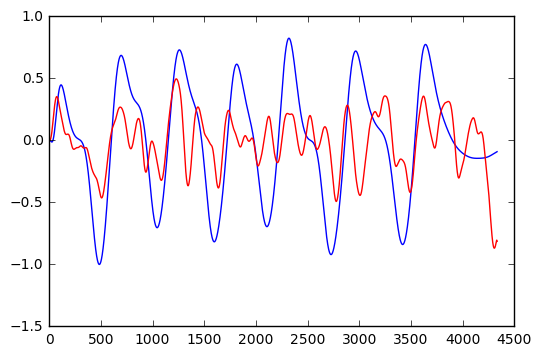

In [162]:
plt.clf()
plt.plot(tys_0_f,'b')
plt.plot(tys_pred_f,'r')
plt.savefig(figure_name+'pred')

In [163]:
cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

cor_smooth

0.46676278618927847

In [ ]:
plt.plot(tys_pred,'b')

In [62]:
cor_smooth

0.75146738493969045

In [150]:
model.save('end_corsmooth73')

In [ ]:
# fit model
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=nb_val_samples, 
                validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

# plot progress
plt.clf()
plt.plot(history.history['val_loss'])
plt.savefig(figure_name+'prog')

# test the best model

model = load_model(path_to_save_model_par)

tys_pred = model.predict(txs_0)

sampling_rate = 2000
tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_pred,'b')
plt.plot(tys_pred_f,'c')
plt.savefig(figure_name+'pred')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

#send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

#send_slack_message("Prediction:")
#send_slack_picture(figure_name+'pred'+'.png')

#send_slack_message("Training history:")
#send_slack_picture(figure_name+'prog'+'.png')

In [137]:
tys_0.shape

(4434, 1)

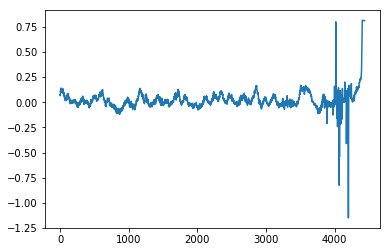

In [159]:
plt.plot(tys_pred[:,0])
#tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

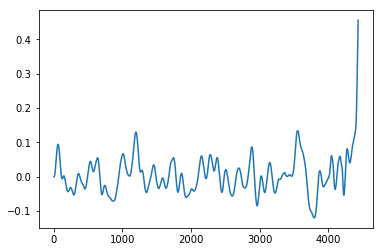

In [160]:
plt.plot(tys_pred_f[:,0])

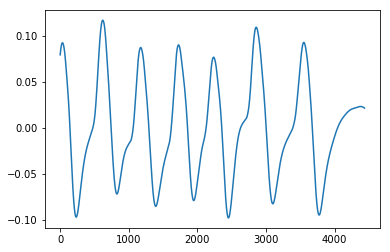

In [162]:
plt.plot(tys_0[:,0])
#tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

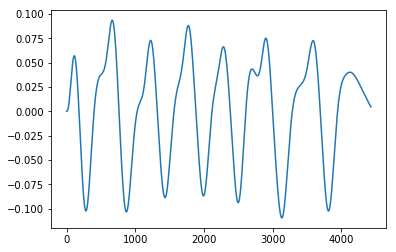

In [163]:
plt.plot(tys_0_f[:,0])

In [134]:
cor = np.corrcoef(tys_0[0:-500,0],tys_pred[0:-500,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[0:-500,0],tys_pred_f[0:-500,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')

In [26]:
cor_smooth

0.23354311152330565

#### Choose the variable to iterate over here:

In [35]:
## var_name = [ k for k,v in locals().iteritems() if v is var][0] ## sample

In [36]:
var_name = 'dense2_n' # MODIFY VARIABLE NAME HERE

#### Set directory to save best models and figures

In [37]:
dirname = var_name

if not os.path.exists(dirname):
    os.makedirs(dirname)

In [38]:
dirname

'dense2_n'

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1000, 100, callbacks=[<keras.ca..., validation_data=<generator..., verbose=2, validation_steps=500)`


Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.09514, saving model to dense2_n/savedmodel_10
18s - loss: 0.1173 - mean_squared_error: 0.1173 - val_loss: 0.0951 - val_mean_squared_error: 0.0951
Epoch 2/100
Epoch 00001: val_loss improved from 0.09514 to 0.07605, saving model to dense2_n/savedmodel_10
11s - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.0761 - val_mean_squared_error: 0.0761
Epoch 3/100
Epoch 00002: val_loss did not improve
11s - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0811 - val_mean_squared_error: 0.0811
Epoch 4/100
Epoch 00003: val_loss did not improve
11s - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 5/100
Epoch 00004: val_loss did not improve
11s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 6/100
Epoch 00005: val_loss did not improve
11s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0779 - val_mean_squared_erro

ReadTimeout: HTTPSConnectionPool(host='slack.com', port=443): Read timed out. (read timeout=10)

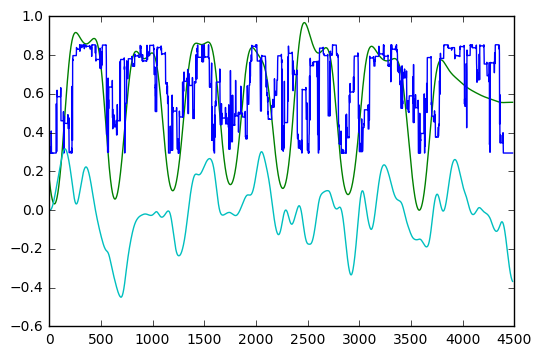

In [108]:
start_time = time()
send_slack_message('New job started at '+ strftime("%H:%M:%S, %Y-%m-%d", gmtime()))

it_range = np.arange(10,200,10)

cors = np.zeros(it_range.shape)
cors_smooth = np.zeros(it_range.shape)

k = 0

for it in it_range:
    
    dense2_n = it # MODIFY VARIABLE NAME HERE
    
    # path to save model
    path_to_save_model_par = dirname+'/'+'savedmodel'+'_'+str(it)
    figure_name = path_to_save_model_par
    
    # build the network
    input_seq = Input(shape=(slice_len, 4))
    
    inputbn = BatchNormalization(axis = 1)(input_seq)
    
    convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu')(inputbn)
    pooled = MaxPooling1D()(convolved)
    flat = Flatten()(pooled)
    dense1 = Dense(dense1_n, activation=dense1_act)(flat)
    dense1do = Dropout(do)(dense1)
    dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
    dense2do = Dropout(0.3)(dense2)
    out = Dense(1, activation='linear')(dense2do)
    model = Model(input=input_seq, output=out)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    
    # early stopping
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=2, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=2,
                               save_best_only=True, mode='auto', period=1)

    # fit model
    history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=2, nb_val_samples=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

    # plot progress
    plt.clf()
    plt.plot(history.history['val_loss'])
    plt.savefig(figure_name+'prog')
    
    
    # test the best model
    
    model = load_model(path_to_save_model_par)
    
    tys_pred = model.predict(txs_0)
    
    sampling_rate = 200
    tys_pred_f = butter_bandpass_filter(tys_pred.T, 0.1, 1, sampling_rate, order=3, how_to_filt = 'simultaneously').T
    
    plt.clf()
    plt.plot(tys_0,'g')
    plt.plot(tys_pred,'b')
    plt.plot(tys_pred_f,'c')
    plt.savefig(figure_name+'pred')
    
    cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
    cor = cor[0,1]
    cor_smooth = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])
    cor_smooth = cor_smooth[0,1]
    
    cors[k] = cor
    
    cors_smooth[k] = cor_smooth
    
    k = k + 1
    
    
    send_slack_message("\nFor "+dirname+"="+str(it)+":"+"\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

    send_slack_message("Prediction:")
    send_slack_picture(figure_name+'pred'+'.png')
    
    send_slack_message("Training history:")
    send_slack_picture(figure_name+'prog'+'.png')

plt.clf()
maxi = np.argmax(cors_smooth)
plt.plot(cors_smooth)
plt.savefig('cors_smooth_'+dirname)

send_slack_message("Corrcoef(par):")
send_slack_picture('cors_smooth_'+dirname+'.png')

send_slack_message("Job's done!")
elapsed_time = time() - start_time
send_slack_message("Elapsed time: "+ str(elapsed_time))




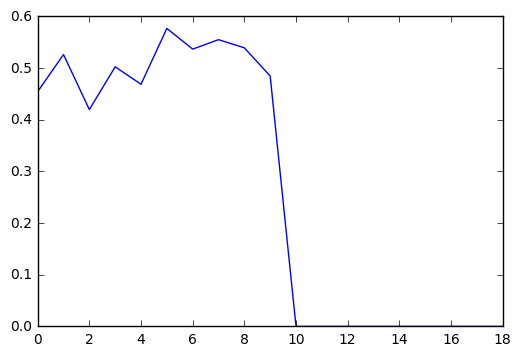

In [109]:
plt.clf()
maxi = np.argmax(cors_smooth)
plt.plot(cors)
plt.savefig('cors_'+dirname)


In [68]:
send_slack_message(teststr)

NameError: name 'teststr' is not defined

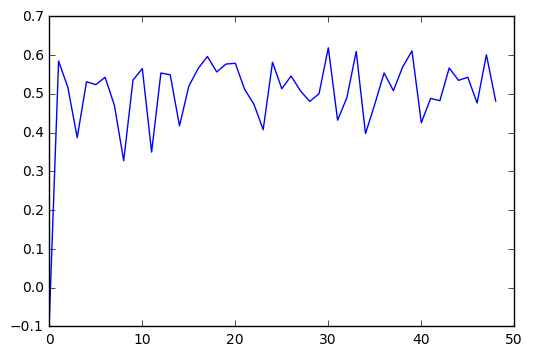

In [28]:
np.corrcoef([1, 2, 8],[2, 4, 16])

array([[ 1.,  1.],
       [ 1.,  1.]])

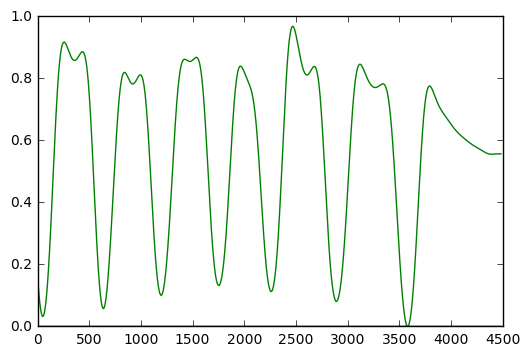

In [111]:

plt.clf()
plt.plot(tys_0,'g')

plt.plot(tys_pred_f,'b')
plt.savefig(figure_name+'pred')

In [114]:
tys_pred_f

array([[  1.07887035e-06],
       [  1.10218862e-06],
       [  1.04646352e-06],
       ..., 
       [  9.01374938e-07],
       [  9.01374938e-07],
       [  9.01374938e-07]])

In [119]:
 tys_pred_f = butter_bandpass_filter(tys_pred.T, 0.1, 1, sampling_rate, order=3, how_to_filt = 'simultaneously').T

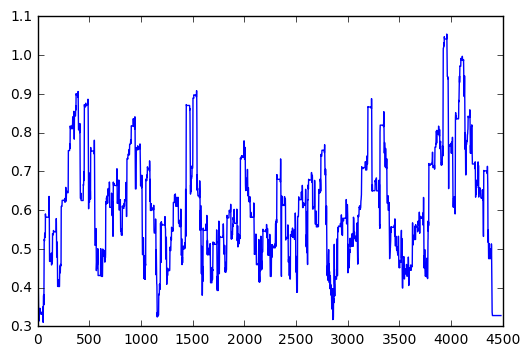

In [120]:
plt.plot(tys_pred)

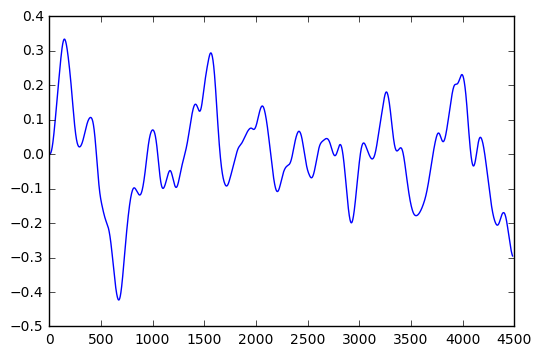

In [121]:
plt.plot(tys_pred_f)